In [38]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Load data

In [2]:
df = pd.read_excel('data/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# 송장 날짜 필드 유형 -> datetime 
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

# 연도 필드 생성
df['InvoiveYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)


# 각 행에 대한 통화 계산 
df['Monetary'] = df['UnitPrice'] * df['Quantity']

# YearMonth - Monetary 열을 활용해 새 데이터프레임 생성
monetary = df.groupby(['InvoiveYearMonth'])['Monetary'].sum().reset_index()


In [4]:
monetary

,InvoiveYearMonth,Monetary
0,201012,748957.020
1,201101,560000.260
2,201102,498062.650
3,201103,683267.080
4,201104,493207.121
5,201105,723333.510
6,201106,691123.120
7,201107,681300.111
8,201108,682680.510
9,201109,1019687.622


# 고객세분화
1. 낮은 가치 : 다른 사람들보다 덜 활동적이고 구매자/방문 빈도가 매우 낮고 매우 낮은(0) 수익을 창출하는 고객
2. 중간 가치 : 상당히 빈번하고 중간 정도의 수익을 창출하는 고객
3. 높은 가치 : 높은 수익, 빈도 및 낮은 비활성 고객 -> 기업은 항상 이러한 고객을 유지하기 원함

## 최신성(Recency)
- 각 고객의 가장 최근 구매 날짜를 찾아 며칠동안 비활성 상태인지 확인
- 각 고객의 비활성 일수에 대해 **K-means** 클러스터링을 적용하여 고객에게 최근성 점수 할당

In [5]:
# user DF 만들기
# user ID를 unique하게 
user = pd.DataFrame(df['CustomerID'].unique())
user.columns = ['CustomerID']

# 가장 최신 거래일자(InvoiceDate.max) 가져오기
max_purchase = df.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns=['CustomerID', 'MaxPurchaseDate']

# 최신성 계산
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
max_purchase

# user df와 max_purchase df merge
user = pd.merge(user, max_purchase[['CustomerID', 'Recency']], on='CustomerID')
user.head()


,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,12583.0,2
3,13748.0,95
4,15100.0,329


In [6]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [7]:
sse = {}
recency = user[['Recency']]

for k in tqdm(range(1, 10)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_

100%|██████████| 9/9 [00:00<00:00, 12.31it/s]


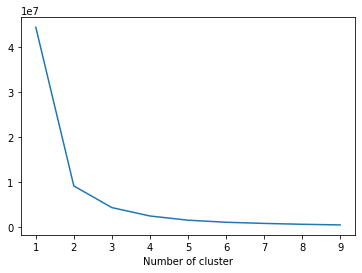

In [8]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

- 그래프상으로는 3개의 클러스터
- 비즈니스 요구 사항에 따라 더 적거나 더 많은 클러스터 사용 가능 -> 이 예시 : 4개 사용

In [9]:
# recency 로 4개의 클러스터를 만들고 user df에 추가
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

In [10]:
# cluster numbers로 정렬하는 함수
def order_cluster(cluster_field_name, target_field_name, data, ascending):
    
    new_cluster_field_name = 'new_'+cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    data_new['index'] = data_new.index
    
    data_final = pd.merge(data, data_new[[cluster_field_name, 'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name], axis=1)
    data_final = data_final.rename(columns={'index':cluster_field_name})
    
    return data_final

In [11]:
user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,2
1,13047.0,31,3
2,12583.0,2,3
3,13748.0,95,1
4,15100.0,329,2


In [12]:

user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,3
1,15100.0,329,3
2,18074.0,373,3
3,16250.0,260,3
4,13747.0,373,3


In [13]:
max(user.Recency)

373

In [14]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2167.0,17.538533,13.320860,0.0,6.0,16.0,28.00,48.0
1,1072.0,79.278918,23.875838,49.0,59.0,73.0,95.00,134.0
2,627.0,189.451356,32.948533,135.0,161.0,187.0,217.00,249.0
3,506.0,308.851779,39.144563,250.0,274.0,305.0,350.75,373.0


# Frequency

In [15]:
user_freq = df.groupby('CustomerID').InvoiceNo.count().reset_index()
user_freq.columns = ['CustomerID', 'Frequency']
user = pd.merge(user, user_freq, on='CustomerID')
user

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,3,312
1,15100.0,329,3,6
2,18074.0,373,3,13
3,16250.0,260,3,24
4,13747.0,373,3,1
...,...,...,...,...
4367,13296.0,136,2,5
4368,17693.0,135,2,18
4369,15372.0,136,2,27
4370,13194.0,135,2,3


In [16]:
user.Frequency.isna().sum()

0

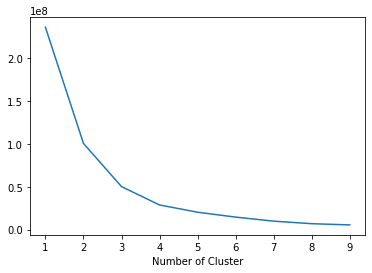

In [17]:
sse = {}
freq = user_freq[['Frequency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(freq)
    freq['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Cluster")
plt.show()

In [18]:
# cluster_num : 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FreqCluster'] = kmeans.predict(user[['Frequency']])
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FreqCluster
0,17850.0,301,3,312,2
1,15100.0,329,3,6,0
2,18074.0,373,3,13,0
3,16250.0,260,3,24,0
4,13747.0,373,3,1,0


In [19]:
max(user_freq['Frequency'])

7983

In [20]:
user = order_cluster('FreqCluster', 'Frequency', user, True)
user

,CustomerID,Recency,RecencyCluster,Frequency,FreqCluster
0,17850.0,301,3,312,1
1,15808.0,305,3,210,1
2,13047.0,31,0,196,1
3,12583.0,2,0,251,1
4,14688.0,7,0,359,1
...,...,...,...,...,...
4367,14456.0,4,0,977,2
4368,12748.0,0,0,4642,3
4369,14911.0,0,0,5903,3
4370,17841.0,1,0,7983,3


# Monetary

In [21]:
user_mon = df.groupby('CustomerID').Monetary.sum().reset_index()
user_mon.columns = ['CustomerID', 'Monetary']
user = pd.merge(user, user_mon, how='left', on='CustomerID')
user

,CustomerID,Recency,RecencyCluster,Frequency,FreqCluster,Monetary
0,17850.0,301,3,312,1,5288.63
1,15808.0,305,3,210,1,3724.77
2,13047.0,31,0,196,1,3079.10
3,12583.0,2,0,251,1,7187.34
4,14688.0,7,0,359,1,5107.38
...,...,...,...,...,...,...
4367,14456.0,4,0,977,2,3047.63
4368,12748.0,0,0,4642,3,29072.10
4369,14911.0,0,0,5903,3,132572.62
4370,17841.0,1,0,7983,3,40340.78


In [22]:
user.Monetary.isna().sum()

0

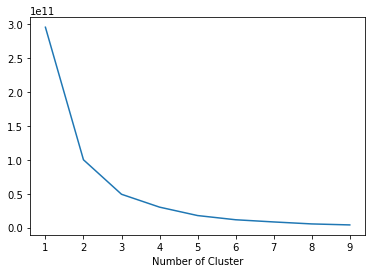

In [23]:
sse = {}
mone = user_mon[['Monetary']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(mone)
    mone['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Cluster")
plt.show()

In [24]:
# cluster_num : 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Monetary']])
user['MoneCluster'] = kmeans.predict(user[['Monetary']])
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FreqCluster,Monetary,MoneCluster
0,17850.0,301,3,312,1,5288.63,0
1,15808.0,305,3,210,1,3724.77,0
2,13047.0,31,0,196,1,3079.10,0
3,12583.0,2,0,251,1,7187.34,0
4,14688.0,7,0,359,1,5107.38,0


In [25]:
max(user['Monetary'])

279489.0199999999

In [26]:
user = order_cluster('MoneCluster', 'Monetary', user, True)
user

,CustomerID,Recency,RecencyCluster,Frequency,FreqCluster,Monetary,MoneCluster
0,17850.0,301,3,312,1,5288.63,0
1,15808.0,305,3,210,1,3724.77,0
2,13047.0,31,0,196,1,3079.10,0
3,12583.0,2,0,251,1,7187.34,0
4,14688.0,7,0,359,1,5107.38,0
...,...,...,...,...,...,...,...
4367,12748.0,0,0,4642,3,29072.10,1
4368,17841.0,1,0,7983,3,40340.78,1
4369,17450.0,7,0,351,1,187482.17,3
4370,18102.0,0,0,433,1,256438.49,3


# Overall 점수 계산

In [27]:
user['OverallScore'] = user['RecencyCluster'] + user['FreqCluster'] + user['MoneCluster']
user.head(2)

,CustomerID,Recency,RecencyCluster,Frequency,FreqCluster,Monetary,MoneCluster,OverallScore
0,17850.0,301,3,312,1,5288.63,0,4
1,15808.0,305,3,210,1,3724.77,0,4


In [28]:
user.groupby('OverallScore')['Recency', 'Frequency', 'Monetary'].mean()

<ipython-input-28-df6b25c73e47>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user.groupby('OverallScore')['Recency', 'Frequency', 'Monetary'].mean()


,Recency,Frequency,Monetary
OverallScore,,,
0,19.207885,66.073477,1190.082838
1,61.545004,115.058824,1824.852170
2,162.491957,95.404826,2194.031597
3,298.376426,51.332700,1383.659734
4,74.583333,1882.083333,74938.799167
5,1.333333,4372.000000,156394.183333


# 고객 가치 나누기
- 0-2: 낮음
- 2-4: 가치 있음
- 5+ : 높은 가치

In [29]:
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore'] >2, 'Segment'] = 'Mid-Value'
user.loc[user['OverallScore'] >4, 'Segment'] = 'High-Value'
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FreqCluster,Monetary,MoneCluster,OverallScore,Segment
0,17850.0,301,3,312,1,5288.63,0,4,Mid-Value
1,15808.0,305,3,210,1,3724.77,0,4,Mid-Value
2,13047.0,31,0,196,1,3079.10,0,1,Low-Value
3,12583.0,2,0,251,1,7187.34,0,1,Low-Value
4,14688.0,7,0,359,1,5107.38,0,1,Low-Value


In [30]:
user[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,91.047118,93.053294,1898.459701
std,100.765435,232.471608,8219.345141
min,0.000000,1.000000,-4287.630000
25%,16.000000,17.000000,293.362500
50%,49.000000,42.000000,648.075000
75%,142.000000,102.000000,1611.725000
max,373.000000,7983.000000,279489.020000


- Recency 평균은 91, 중앙값 49 
- Monetary 음수 : 환불

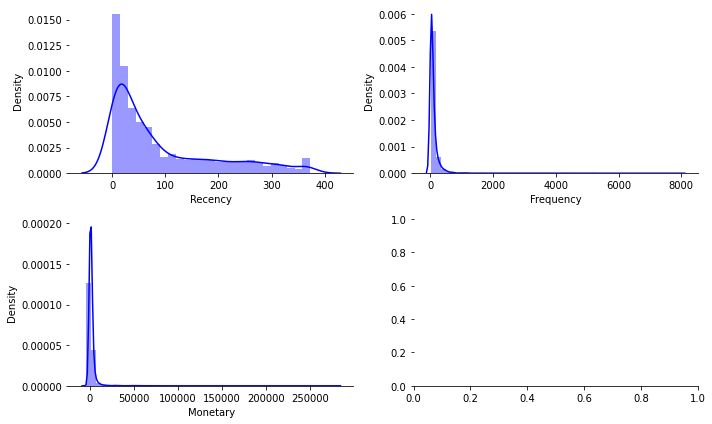

In [39]:
f, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.despine(left=True)

# 데이터 그리기
sns.distplot(user.Recency, color='b', ax=axes[0,0])
sns.distplot(user.Frequency, color='b', ax=axes[0,1])
sns.distplot(user.Monetary, color='b', ax=axes[1,0])

plt.tight_layout()

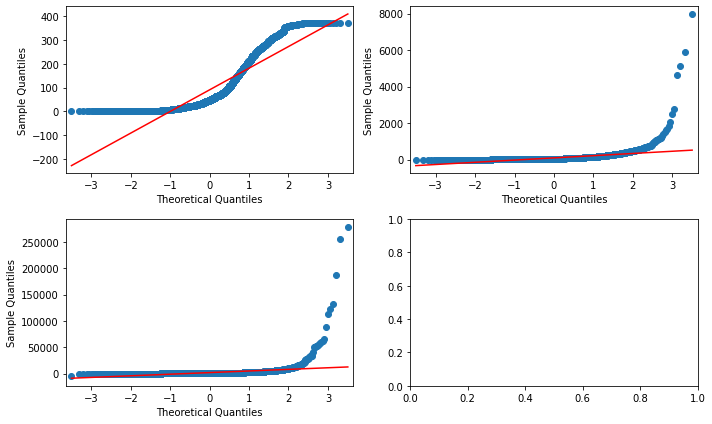

In [44]:
from statsmodels.graphics.gofplots import qqplot

f, axes = plt.subplots(2, 2, figsize=(10, 6))

qqplot(user.Recency, line='r', ax=axes[0,0], label='Recency')
qqplot(user.Frequency, line='r', ax=axes[0,1], label='Frequency')
qqplot(user.Monetary, line='r', ax=axes[1,0], label='Monetary')

plt.tight_layout()

##### Q-Q Plot
- 정규화를 검토하기 위한 그래프
- 직선: 정규분포값, 점선 : 실제 데이터의 값
- 점선과 직선이 일치할수록, 데이터는 정규분포를 따름

##### 데이터
- 검정통계량, 분포, QQ-plot -> "데이터가 정규분포를 따르지 않는다"
- 따라서 예측을 위해 **비모수적 프레임워크**를 사용하는 것이 좋음

## 고객 세분화 전략
- 고가치 고객 : 유지율 향상
- 중간가치 고객 : 유지율향상 및 빈도 증가
- 저가치 고객 : 빈도 증가

# 고객평생가치(CLTV)

1) 3, 6, 12, 24개월 중 원하는 기간을 선택<br>
2) 총 수익 - 총 비용 방정식을 사용해 해당 기간 특정 기간의 각 고객에 대한 CLTV 계산

##### CLTV 예측 과정
1. CLTV 계산을 위한 적절한 시간 프레임 정의
2. 미래를 예측하고 생성하는데 사용할 기능 식별
3. ML 모델 학습을 위한 CLTV 계산
4. ML 모델 빌드 및 실행
5. 모델이 유용한지 확인

In [84]:
from datetime import datetime

In [92]:
# 각 고객 ID에 대한 RFM 점수 얻음
# 데이터 세트 분할 - 3개월 데이터로 RFM 계산 -> 다음 6개월 데이터로 예측

# 3m 및 6m 데이터 프레임 생성
m3 = df[(df.InvoiceDate < datetime(2011,6,1)) & (df.InvoiceDate >= datetime(2011,3,1)) ].reset_index(drop=True)
m6 = df[(df.InvoiceDate >= datetime(2011, 6, 1)) & (df.InvoiceDate < datetime(2011, 12,1))].reset_index(drop=True)

In [93]:
len(df), len(m3), len(m6)

(541909, 103694, 307355)

In [ ]:
# 최신성(Recency) 계산 함수
def Recency(input_df, user_df):
    max_purchase = input_df.groupby('CustomerID').InvoiceDate.max().reset_index()
    max_purchase.columns=['CustomerID', 'MaxPurchaseDate']

    # 최신성 계산
    max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

    # user df와 max_purchase df merge
    user_df = pd.merge(user_df, max_purchase[['CustomerID', 'Recency']], on='CustomerID')
    
    # recency 로 4개의 클러스터를 만들고 user df에 추가
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(user_df[['Recency']])
    user_df['RecencyCluster'] = kmeans.predict(user_df[['Recency']])
    
    user_df = order_cluster('RecencyCluster', 'Recency', user_df, True)
    
    return user_df
